# Collision of Two Jovian Planets

## Roadmap
* Initialization
    * Initialize position
        * Distribute particles to recover $\rho = \rho_c * sin(\zeta) / \zeta $
    * Initialize velocity
        * Uniform velocity for every particle in planet
    * Initialize mass
        * Every particle gets the same mass
            * For now? Or for always?
    * Assign density $\rho_i$
        * Use [equation 4.5] to assign density
        * $ \rho(r) = \sum_{j=1}^N \rho_j (r)$
        * Actually, it looks like I can more simply initialize density using $\rho = \rho_c * sin(\zeta) / \zeta $
    * Choose time scale
        * Time must satisfy the CFL condition [equation 4.12] 
        
* Calculate gravitational forces $\nabla \Phi_i$
    * First pass can use brute force O(N^2) method [equation 3.1]
    * Second pass would use trees or FFT
    
* Calculate pressure $P_i$, given density $\rho_i$
    * For the outer layer, $P = \frac{R_g}{\mu} \rho T $
    * More generaly, the 'entire'?? planet can be modeled with $P = K \rho ^\gamma$ 
    * [Equations 4.14 - 4.17] go into more detail

* Calculate $\nabla P_i$
    * Can be done by combining [equations 4.3, 4.4, 4.5, and 4.9]
        * First: calculate Gaussian kernel
        * Second: multiply Gaussian kernel by mass of a specified particle j (this can be done in batch)
        * Third: Sum over local $\rho_j$ to find $\rho_i$
        * Fourth: Sum [ (mass * pressure_j/ density_j) * gradient(kernel) ]
    * Smoothing length
        * First pass: uniform
        * Second pass: locally adaptive

* Calculate change in velocity $v_i$ [equation 4.2], given pressure, density, and gravitational forces
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
* Calculate change in position $r_i$ [equation], given velocity
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
## Weird Things / Concerning Things / Bugs
* When I initalized 100 particles, I ended up with 94 after all of that
    * We lose some of them when rounding, but we shouldn't lose 6
* The max number of particles is not located at the outermost edge of Jupiter
    * This distribution comes from [equation 4.18]. The error might come from the fact that I didn't normalize alpha = 1, rho_c = 1
* Time step is 1e-21 for gravitational forces

## Notes
* Changed number of partitions to 10
* Density of Jupiter is ~1.33g/cm^3
        
### Initialize Libraries

In [2]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import time

### Initialize Model Constants

In [3]:
RJupiter = 6.99e9    # cm

gamma = 2
G = 6.67e-8    # dyne*cm^2/g^2

rhoC = 5    # g/cm^3, central density
PC = 6.5e13    # dyne/cm^2
TC = 22000    # K

K = 2.6e12    # dyne*cm^4/g^2

alpha = np.sqrt(K/(2*np.pi*G))

### Initialize Positions of Planets

In [10]:
N1 = 1000    # Particles in Planet 1
N2 = N1     # Particles in Planet 2

# Equations 4.17
# Use partition to give initial positions of particles
partitionNum = 10     
rSpace = np.linspace(0, RJupiter, partitionNum)
zetaSpace = rSpace/alpha

# Number of particles in each region of delta(r) / delta(zeta)
NDistribution = []    
for i in range(1,len(zetaSpace)):
    zeta2 = zetaSpace[i]
    zeta1 = zetaSpace[i-1]
    NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
                         *N1/np.pi)
    
NDistribution = np.array(NDistribution)
NDistribution = np.round(NDistribution)

# Create radial distribution
radiusDistribution = []
i = 0
for N in NDistribution:
    radiusDistribution.append(np.random.uniform(rSpace[i], rSpace[i+1], size=N))
    i += 1

# Flatten radial array
radiusDistribution = [item for sublist in radiusDistribution for item in sublist]
radiusDistribution = np.array(radiusDistribution)

# Create angle distribution
thetaDistribution = np.random.uniform(0, 2*np.pi, size=len(radiusDistribution))

c:\Users\oromi_000\Anaconda\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Plot Initial Spatial Distribution

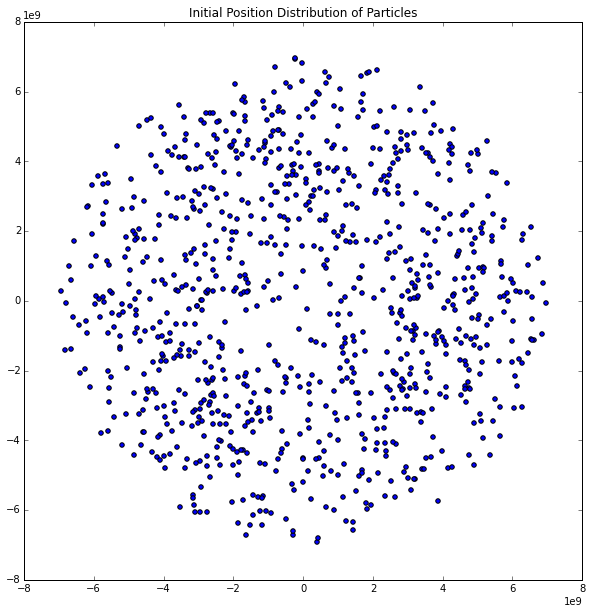

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), radiusDistribution*np.sin(thetaDistribution))
plt.title("Initial Position Distribution of Particles")
plt.show()

### Model Initial Densities
* Currently modeling density as 4 distinct regions
    * Might want to follow up with the smoothing that comes with the density_j summation
* Modeling density as a continuous function of r now, using [equation 4.17]

In [31]:
rhoDistribution = rhoC * np.sin(radiusDistribution/alpha) / (radiusDistribution/alpha)

# rhoDistribution = []
# for i in range(len(rho)):
#     rhoDistribution.append(rho[i] * np.ones(NDistribution[i]))

# # Flatten rhodistribution
# rhoDistribution = [item for sublist in rhoDistribution for item in sublist]
# rhoDistribution = np.array(rhoDistribution)

print radiusDistribution.shape, rhoDistribution.shape

(950L,) (950L,)
2.61653770844


### Plot Initial Densities

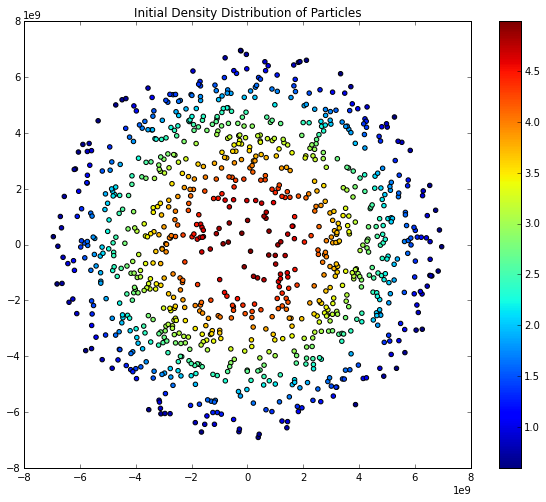

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
plt.title("Initial Density Distribution of Particles")
plt.colorbar()
plt.show()

### Model Initial Pressure Distribution
* Currently modeling as simply polytropic
    * Might want to find P by solving the ODE [equation 4.14]

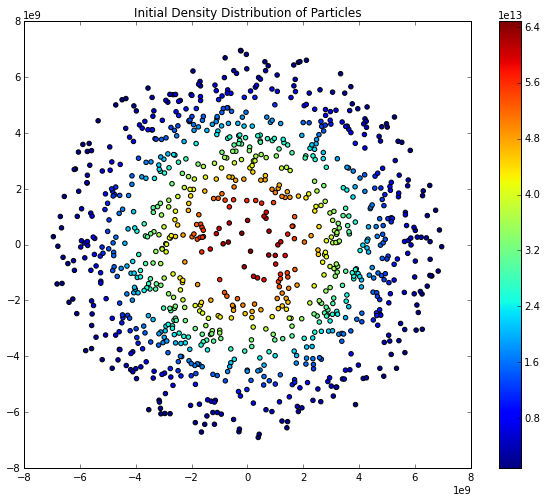

In [26]:
pressureDistribution = K * rhoDistribution ** gamma

plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=pressureDistribution)
plt.title("Initial Density Distribution of Particles")
plt.colorbar()
plt.show()

### Model Initial Mass Distribution
* Assume particle mass is uniform

In [28]:
MJupiter = 1.89e30    # grams
MParticle = MJupiter / len(rhoDistribution)    # Assume uniform mass distribution

### Convert from Polar to Cartesian Coordinates

In [29]:
def polar2cart(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

def cart2radial(xy):
    return np.sqrt(xyDistribution[:,0]**2 + xyDistribution[:,1]**2)

xyDistribution = polar2cart(radiusDistribution, thetaDistribution)

print xyDistribution.shape

(950L, 2L)


### Model Initial Velocities

In [115]:
velocityDistribution = np.zeros_like(xyDistribution)

### Recalculate Density, using Smoothing Kernel

In [30]:
def W(xyDistribution, h=.03e4 * RJupiter/N1):
    '''
    h scaled by 1e4 appears to give largest smoothing coefficients
    '''
    rDist = cart2radial(xyDistribution)
    smoothing = np.zeros_like(rDist)

    coeff = 1/(h * np.sqrt(np.pi))**3
    for i in range(len(rDist)):
        vecMag = 0
        for j in range(len(rDist)):
            if j != i:
                dr = xyDistribution[i,0] - xyDistribution[j,0]
                drSquared = dr * dr
                vecMag += drSquared
        smoothing[i] = coeff * np.exp(-(np.sqrt(vecMag)/h)**2)
    return smoothing

In [ ]:
rho_j = W(xyDistribution)*MParticle
print np.mean(xyDistribution)

### Model Initial Gravitational Force

#### Need to Run Entire Code to get reliable visuals! 

* Looking into https://www.wakari.io/sharing/bundle/yves/Continuum_N_Body_Simulation_Numba to do calcs
* Here has better approaches http://www.scholarpedia.org/article/N-body_simulations, but no code
* Ripping code from here: http://hilpisch.com/Continuum_N_Body_Simulation_Numba_27072013.html#/5/1

* The difference in position appears directly proportional to the size of time step

* A time step of e-21 allows the planet to stay relatively clumped up after 10000 RK1 steps
    * ie: Less than 10 particles were ejected into oblivion

In [ ]:
def nbody(particle, particlev):
    '''
    Runs RK1 to update velocity and position. Takes numpy arrays as input.
    
    * POSSIBLE BUG * - They don't actually take the 3/2 power of dr
    '''
    t0 = time.time(); nSteps = 100; dt = 1e-21
#    XPositionHistory = np.zeros((len(xyDistribution), nSteps))
#    velocityHistory = np.zeros((len(xyDistribution), nSteps))

    for step in range(1, nSteps + 1, 1):
        for i in range(len(xyDistribution)):
            Fx = 0.0; Fy = 0.0; # Fz = 0.0
            for j in range(len(xyDistribution)):
                if j != i:
                    dx = particle[j,0] - particle[i,0]
                    dy = particle[j,1] - particle[i,1]
                    drSquared = dx * dx + dy * dy # + dz * dz
                    drPowerN32 =  G * MParticle ** 2 / (drSquared + np.sqrt(drSquared))
                    Fx += dx * drPowerN32
                    Fy += dy * drPowerN32
                particlev[i, 0] += dt * Fx
                particlev[i, 1] += dt * Fy
        for i in range(len(xyDistribution)):
            particle[i,0] += particlev[i,0] * dt
            particle[i,1] += particlev[i,1] * dt
#            particle[i,2] += particlev[i,2] * dt
#        XPositionHistory[:,step] = particle[i,0]


In [ ]:
xyDistributionOld = np.copy(xyDistribution)

nbody_nb = nb.autojit(nbody)
firstrun = nbody_nb(xyDistribution, velocityDistribution)

In [ ]:
print xyDistribution - xyDistributionOld

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.scatter(xyDistributionOld[:,0], xyDistributionOld[:,1], c='y')
plt.xlim(-0.5e11, 0.5e11)
plt.ylim(-0.5e11, 0.5e11)
plt.title("Close-up of the Planet after 10K Time Steps")
plt.plot()

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistributionOld[:,0], xyDistributionOld[:,1], c='y')
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.title("All the Particles of the Planet after 10K Time Steps")
plt.plot()